In [183]:
import math
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
from IPython.display import display
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [184]:
#import and view dataset 
df = pd.read_csv('NEW_YORK_Offenses.csv')
df.head(10)

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0.000,nan,0,0,0,12,2,10,0,0.000
1,Addison Town and Village,"2,577",3,0.000,nan,0,0,3,24,3,20,1,0.000
2,Akron Village,"2,846",3,0.000,nan,0,0,3,16,1,15,0,0.000
3,Albany,"97,956",791,8.000,nan,30,227,526,"4,090",705,"3,243",142,nan
4,Albion Village,"6,388",23,0.000,nan,3,4,16,223,53,165,5,nan
5,Alfred Village,"4,089",5,0.000,nan,0,3,2,46,10,36,0,nan
6,Allegany Village,"1,781",3,0.000,nan,0,0,3,10,0,10,0,0.000
7,Amherst Town,"118,296",107,1.000,nan,7,31,68,"2,118",204,"1,882",32,3.000
8,Amityville Village,"9,519",9,0.000,nan,2,4,3,210,16,188,6,1.000
9,Amsterdam,"18,182",30,0.000,nan,0,12,18,405,99,291,15,0.000


In [185]:
#clean data
df.fillna(0, inplace=True)
for col in df.iloc[:, 1:]:
    df[col] = df[col].replace('[^0-9]+', '', regex=True)
    df[col] = df[col].astype('int64')
#rename columns for ease of reference
df.rename(columns={'City':'city','Violent\ncrime': 'violent_crime', 'Rape\n(revised\ndefinition)1': 'rape1', 'Rape\n(legacy\ndefinition)2': 'rape2', 'Aggravated\nassault': 'assault','Population': 'population', 'Murder and\nnonnegligent\nmanslaughter':'murder','Robbery': 'robbery','Property\ncrime': 'property_crime','Burglary':'burglary','Larceny-\ntheft': 'larceny_theft', 'Motor\nvehicle\ntheft': 'motor_vehicle_theft', 'Arson3':'arson'}, inplace=True)
df.head(10)

,city,population,violent_crime,murder,rape1,rape2,robbery,assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson
0,Adams Village,1861,0,0,0,0,0,0,12,2,10,0,0
1,Addison Town and Village,2577,3,0,0,0,0,3,24,3,20,1,0
2,Akron Village,2846,3,0,0,0,0,3,16,1,15,0,0
3,Albany,97956,791,8,0,30,227,526,4090,705,3243,142,0
4,Albion Village,6388,23,0,0,3,4,16,223,53,165,5,0
5,Alfred Village,4089,5,0,0,0,3,2,46,10,36,0,0
6,Allegany Village,1781,3,0,0,0,0,3,10,0,10,0,0
7,Amherst Town,118296,107,1,0,7,31,68,2118,204,1882,32,3
8,Amityville Village,9519,9,0,0,2,4,3,210,16,188,6,1
9,Amsterdam,18182,30,0,0,0,12,18,405,99,291,15,0


### Original Formula: Propertycrime=α+Population+Population2+Murder+Robbery
 

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 13 columns):
city                   351 non-null object
population             351 non-null int64
violent_crime          351 non-null int64
murder                 351 non-null int64
rape1                  351 non-null int64
rape2                  351 non-null int64
robbery                351 non-null int64
assault                351 non-null int64
property_crime         351 non-null int64
burglary               351 non-null int64
larceny_theft          351 non-null int64
motor_vehicle_theft    351 non-null int64
arson                  351 non-null int64
dtypes: int64(12), object(1)
memory usage: 34.3+ KB


In [187]:
#create column
df['population2'] = np.power(df['population'], 2)
#create the two categorical variables 
df['murder'] = np.where((df['murder'] > 0), 1, 0) 
df['robbery'] = np.where((df['robbery'] > 0), 1, 0)  
df.head(10)

,city,population,violent_crime,murder,rape1,rape2,robbery,assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson,population2
0,Adams Village,1861,0,0,0,0,0,0,12,2,10,0,0,3463321
1,Addison Town and Village,2577,3,0,0,0,0,3,24,3,20,1,0,6640929
2,Akron Village,2846,3,0,0,0,0,3,16,1,15,0,0,8099716
3,Albany,97956,791,1,0,30,1,526,4090,705,3243,142,0,9595377936
4,Albion Village,6388,23,0,0,3,1,16,223,53,165,5,0,40806544
5,Alfred Village,4089,5,0,0,0,1,2,46,10,36,0,0,16719921
6,Allegany Village,1781,3,0,0,0,0,3,10,0,10,0,0,3171961
7,Amherst Town,118296,107,1,0,7,1,68,2118,204,1882,32,3,13993943616
8,Amityville Village,9519,9,0,0,2,1,3,210,16,188,6,1,90611361
9,Amsterdam,18182,30,0,0,0,1,18,405,99,291,15,0,330585124


In [188]:
#Stats Models
x = np.column_stack((df['population'], df['population2'], df['murder'],df['robbery']))
x = sm.add_constant(x, prepend=True)

results = smf.OLS(df['property_crime'],x).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 2.223e+04
Date:                Fri, 30 Nov 2018   Prob (F-statistic):               0.00
Time:                        12:24:07   Log-Likelihood:                -2660.8
No. Observations:                 351   AIC:                             5332.
Df Residuals:                     346   BIC:                             5351.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -107.2258     40.380     -2.655      0.0

In [189]:
X = df[['population','population2','murder','robbery']]
correlation_matrix = X.corr()
display(correlation_matrix)

,population,population2,murder,robbery
population,1.000,0.998,0.162,0.065
population2,0.998,1.000,0.133,0.044
murder,0.162,0.133,1.000,0.315
robbery,0.065,0.044,0.315,1.000


We have a very high R2 value (close to 1), which is a warning sign for overfitting. Seems like our dataset is biased by quirks in the data, and will perform less well on the test-set. We'll also adjust our high multicollinearity problem between population and population^2. 

### Updating our model to avoid overfitting 

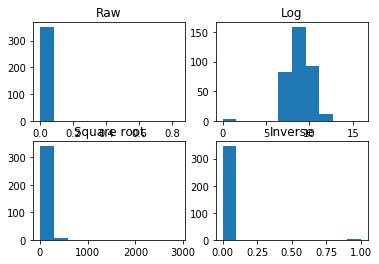

In [190]:
#check for normal distribution amongst continous variables 
fig = plt.figure()

fig.add_subplot(221)
plt.hist(df['population'].dropna())
plt.title('Raw')

fig.add_subplot(222)
plt.hist(np.log(df['population']+1))
plt.title('Log')

fig.add_subplot(223)
plt.hist(np.sqrt(df['population'].dropna()))
plt.title('Square root')

ax3=fig.add_subplot(224)
plt.hist(1/(df['population']+1))
plt.title('Inverse')
plt.show()

#we'll take the log for population instead 

df['population'] = (np.log(df['population']+1))

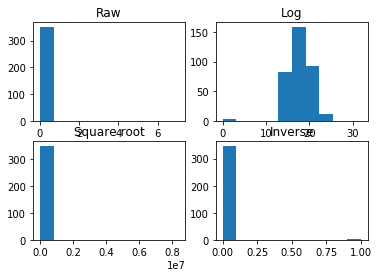

In [191]:
fig = plt.figure()

fig.add_subplot(221)
plt.hist(df['population2'].dropna())
plt.title('Raw')

fig.add_subplot(222)
plt.hist(np.log(df['population2']+1))
plt.title('Log')

fig.add_subplot(223)
plt.hist(np.sqrt(df['population2'].dropna()))
plt.title('Square root')

ax3=fig.add_subplot(224)
plt.hist(1/(df['population2']+1))
plt.title('Inverse')
plt.show()

#take log of population sqrd 
df['population2'] = (np.log(df['population2']+1))

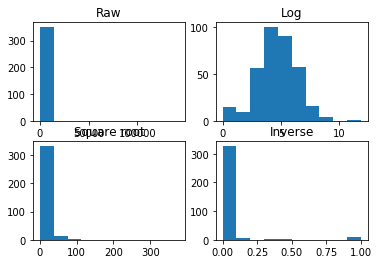

In [192]:
fig = plt.figure()

fig.add_subplot(221)
plt.hist(df['property_crime'].dropna())
plt.title('Raw')

fig.add_subplot(222)
plt.hist(np.log(df['property_crime']+1))
plt.title('Log')

fig.add_subplot(223)
plt.hist(np.sqrt(df['property_crime'].dropna()))
plt.title('Square root')

ax3=fig.add_subplot(224)
plt.hist(1/(df['property_crime']+1))
plt.title('Inverse')
plt.show()

#finally take the log of property crime
df['property_crime'] = (np.log(df['property_crime']+1))

In [193]:
#Stats Models
x = np.column_stack((df['population'], df['murder'],df['robbery']))
x = sm.add_constant(x, prepend=True)

results = smf.OLS(df['property_crime'],x).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     419.0
Date:                Fri, 30 Nov 2018   Prob (F-statistic):          5.81e-115
Time:                        12:24:10   Log-Likelihood:                -423.15
No. Observations:                 351   AIC:                             854.3
Df Residuals:                     347   BIC:                             869.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.5310      0.299     -8.469      0.0

### Adding some new features to better predict

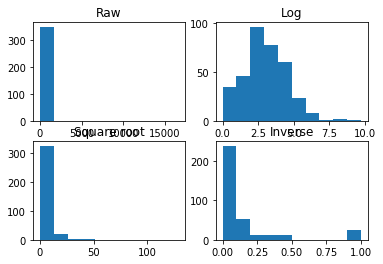

In [194]:
#check for normal distribution amongst continous variables 
fig = plt.figure()

fig.add_subplot(221)
plt.hist(df['burglary'].dropna())
plt.title('Raw')

fig.add_subplot(222)
plt.hist(np.log(df['burglary']+1))
plt.title('Log')

fig.add_subplot(223)
plt.hist(np.sqrt(df['burglary'].dropna()))
plt.title('Square root')

ax3=fig.add_subplot(224)
plt.hist(1/(df['burglary']+1))
plt.title('Inverse')
plt.show()

#we'll take the log for burglary instead 

df['burglary'] = (np.log(df['burglary']+1))

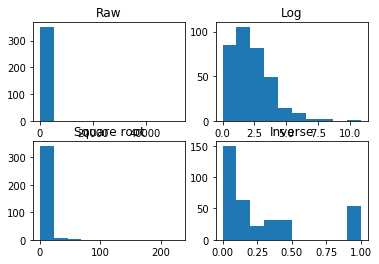

In [195]:
#check for normal distribution amongst continous variables 
fig = plt.figure()

fig.add_subplot(221)
plt.hist(df['violent_crime'].dropna())
plt.title('Raw')

fig.add_subplot(222)
plt.hist(np.log(df['violent_crime']+1))
plt.title('Log')

fig.add_subplot(223)
plt.hist(np.sqrt(df['violent_crime'].dropna()))
plt.title('Square root')

ax3=fig.add_subplot(224)
plt.hist(1/(df['violent_crime']+1))
plt.title('Inverse')
plt.show()
df['violent_crime'] = (np.log(df['violent_crime']+1))

In [197]:
#Stats Models
x = np.column_stack((df['population'], df['burglary'], df['violent_crime'],df['robbery']))
x = sm.add_constant(x, prepend=True)

results = smf.OLS(df['property_crime'],x).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     977.0
Date:                Fri, 30 Nov 2018   Prob (F-statistic):          4.84e-187
Time:                        12:24:18   Log-Likelihood:                -251.48
No. Observations:                 351   AIC:                             513.0
Df Residuals:                     346   BIC:                             532.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1238      0.211     -0.588      0.5

### Testing final model on new dataset 

In [198]:
#import and view second dataset 
df2 = pd.read_csv('Offenses_NYC_2014.csv')
df2.head(10)

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Unnamed: 13
0,Adams Village,"1,851",0,0.000,NaN,0.000,0,0,11,1,10,0,0.000,nan
1,Addison Town and Village,"2,568",2,0.000,NaN,0.000,1,1,49,1,47,1,0.000,nan
2,Afton Village4,820,0,0.000,0,nan,0,0,1,0,1,0,0.000,nan
3,Akron Village,"2,842",1,0.000,NaN,0.000,0,1,17,0,17,0,0.000,nan
4,Albany4,"98,595",802,8.000,54,nan,237,503,"3,888",683,"3,083",122,12.000,nan
5,Albion Village4,"5,872",26,0.000,3,nan,2,21,204,41,159,4,0.000,nan
6,Alexandria Bay Village4,"1,107",0,0.000,0,nan,0,0,7,2,5,0,0.000,nan
7,Alfred Village4,"4,032",11,1.000,1,nan,0,9,30,6,24,0,0.000,nan
8,Altamont Village4,"1,723",1,0.000,0,nan,0,1,2,2,0,0,0.000,nan
9,Amherst Town4,"118,860",128,1.000,16,nan,43,68,"2,066",176,"1,846",44,2.000,nan


In [199]:
#clean dataset 
df2.fillna(0, inplace=True)
for col in df2.iloc[:, 1:]:
    df2[col] = df2[col].replace('[^0-9]+', '', regex=True)
    df2[col] = df2[col].astype('int64') 
#rename columns for ease of reference
df2.rename(columns={'City':'city','Violent\ncrime': 'violent_crime', 'Rape\n(revised\ndefinition)1': 'rape1', 'Rape\n(legacy\ndefinition)2': 'rape2', 'Aggravated\nassault': 'assault','Population': 'population', 'Murder and\nnonnegligent\nmanslaughter':'murder','Robbery': 'robbery','Property\ncrime': 'property_crime','Burglary':'burglary','Larceny-\ntheft': 'larceny_theft', 'Motor\nvehicle\ntheft': 'motor_vehicle_theft', 'Arson3':'arson'}, inplace=True)
df2.head(10)

,city,population,violent_crime,murder,rape1,rape2,robbery,assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson,Unnamed: 13
0,Adams Village,1851,0,0,0,0,0,0,11,1,10,0,0,0
1,Addison Town and Village,2568,2,0,0,0,1,1,49,1,47,1,0,0
2,Afton Village4,820,0,0,0,0,0,0,1,0,1,0,0,0
3,Akron Village,2842,1,0,0,0,0,1,17,0,17,0,0,0
4,Albany4,98595,802,8,54,0,237,503,3888,683,3083,122,12,0
5,Albion Village4,5872,26,0,3,0,2,21,204,41,159,4,0,0
6,Alexandria Bay Village4,1107,0,0,0,0,0,0,7,2,5,0,0,0
7,Alfred Village4,4032,11,1,1,0,0,9,30,6,24,0,0,0
8,Altamont Village4,1723,1,0,0,0,0,1,2,2,0,0,0,0
9,Amherst Town4,118860,128,1,16,0,43,68,2066,176,1846,44,2,0


In [200]:
#create the one categorical variable needed for robbery, adjust the continous variables to be normally distributed, & take the log of the dependent variable 
df2['robbery'] = np.where((df2['robbery'] > 0), 1, 0)  
df2['population'] = (np.log(df2['population']+1))
df2['burglary'] = (np.log(df2['burglary']+1))
df2['violent_crime'] = (np.log(df2['violent_crime']+1))
df2['property_crime'] = (np.log(df2['property_crime']+1))

In [204]:
x = np.column_stack((df2['population'], df2['burglary'], df2['violent_crime'],df2['robbery']))
x = sm.add_constant(x, prepend=True)
results = smf.OLS(df2['property_crime'],x).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     883.3
Date:                Fri, 30 Nov 2018   Prob (F-statistic):          4.11e-188
Time:                        12:29:05   Log-Likelihood:                -329.19
No. Observations:                 376   AIC:                             668.4
Df Residuals:                     371   BIC:                             688.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0406      0.186     -0.218      0.8